In [1]:
from Function.SNNModule import *
from Function.SNN_230327 import SNNModel
from Function.plot_SNN import *
from Function.ReceptiveField_GPU import *
from Function.Stimulation_GPU import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

GPU available: True
CUDA version: 10.1
cpu


In [3]:
sensor_h, sensor_w = 19, 16  # (mm)
pixel_h, pixel_w = 64, 48  # (#)
img_FPS = 60


In [4]:
tensor_delay = torch.empty(7, 7, device = device)

# Fill the top row with 1's
tensor_delay[0, :] = 1

# Fill the remaining elements with numbers from 2 to 34 sequentially
counter = 2
for i in range(1, 7):
    for j in range(7):
        tensor_delay[i, j] = counter
        counter += 1

print(tensor_delay)

flipped_tensor_delay = torch.flip(tensor_delay, [0])

print(flipped_tensor_delay)

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20., 21., 22.],
        [23., 24., 25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34., 35., 36.],
        [37., 38., 39., 40., 41., 42., 43.]])
tensor([[37., 38., 39., 40., 41., 42., 43.],
        [30., 31., 32., 33., 34., 35., 36.],
        [23., 24., 25., 26., 27., 28., 29.],
        [16., 17., 18., 19., 20., 21., 22.],
        [ 9., 10., 11., 12., 13., 14., 15.],
        [ 2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])


In [5]:
SA_rf,[SA_top_h,SA_top_v] = generate_mechanoreceptor_to_afferent_rf(step_size = 3)
RA_rf,[RA_top_h,RA_top_v] = generate_mechanoreceptor_to_afferent_rf(kernel_w=15, kernel_h=15)

print(SA_rf.shape)
print(SA_top_h,SA_top_v)

# receptive_field_optimized = [
#                              torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], device=device)*5,  # Sobel horizontal
#                              torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=device)*5,  # Sobel vertical
#                              torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*5,  # Prewitt horizontal
#                              torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*5,  # Prewitt vertical
#                              torch.tensor([[0, 0, -1], [0, 1, 0], [0, 0, 0]], device=device)*5, # Roberts horizontal
#                              torch.tensor([[-1, 0, 0], [0, 1, 0], [0, 0, 0]], device=device)*5, # Roberts vertical
#                              torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], device=device)*5, # Laplacian mask 1
#                              torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], device=device)*5,
#                             #  torch.tensor([[-1, 1], [-1, 1], [-1, 1]], device=device)*5,
#                             #  torch.tensor([[-1,-1,-1],[1,1,1]], device =device)*5
# ]

receptive_field_optimized = [
                            torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*5,  # Prewitt horizontal
                            torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*5,  # Prewitt vertical
                            torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*5,  # Prewitt horizontal
                            torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*5,  # Prewitt vertical
                            1 * torch.ones((7, 7), device=device),
                            1 * torch.ones((7, 7), device=device),
                            1 * torch.ones((3, 3), device=device),
                            1 * torch.ones((3, 3), device=device)
]

synaptic_delays = [
                    torch.tensor([[0,0,0], [0,0,0], [0,0,0]], device=device),
                    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device)
]

synaptic_delays_top = [
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
    torch.tensor([[0, 0, 0], [1, 1, 1], [4, 4, 4]], device=device)*10,
    torch.tensor([[4, 4, 4], [2, 2, 2], [0, 0, 0]], device=device)*10,
    tensor_delay,
    flipped_tensor_delay,
    torch.tensor([[4, 4, 4], [2, 2, 2], [0, 0, 0]], device=device)*5,
    torch.tensor([[0, 0, 0], [1, 1, 1], [4, 4, 4]], device=device)*5
]

SA_rf_top, SA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=SA_top_v,
                                                                            pixel_w=SA_top_h, step_size=1,device = device)

RA_rf_top, RA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=RA_top_v,
                                                      pixel_w=RA_top_h, step_size=1, device=device)

SA_rf_top_delay, SA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=SA_top_v,
                                              pixel_w=SA_top_h, step_size=1, device=device)

RA_rf_top_delay, RA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=RA_top_v,
                                                      pixel_w=RA_top_h, step_size=1, device=device)


print(SA_rf_length)
print(RA_rf_length)
print(SA_rf_top.device)

Complete! Generated 247 receptive fields from mechanoreceptor to afferents with kernel size 10x10.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 15x15.
torch.Size([247, 3072])
13 19
Complete! Generated 1304 receptive fields from afferents to the top with kernel size 3x3. with step size 16x10
Complete! Generated 168 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
Complete! Generated 1304 receptive fields from afferents to the top with kernel size 3x3. with step size 16x10
Complete! Generated 168 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
[187, 187, 187, 187, 91, 91, 187, 187]
[28, 28, 28, 28, 0, 0, 28, 28]
cpu


In [6]:
# Create Izhikevich layers
SA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_rf), a_decay=1 ,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 8, len(SA_rf_top), a_decay=1,device=device)
    ]

# Create synapses
SA_synapses = [
    Synapse(SA_rf.to(device),synaptic_delays,device = device),
    Synapse(SA_rf_top.to(device),SA_rf_top_delay,device = device)
    ]

RA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_rf), a_decay=1,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_rf_top), a_decay=1,device=device)
    ]

RA_synapses =[
    Synapse(RA_rf.to(device),synaptic_delays,device = device),
    Synapse(RA_rf_top.to(device),RA_rf_top_delay ,device = device)
    ]

layers initialized
layers initialized
Synapses initialized
Synapses initialized
layers initialized
layers initialized
Synapses initialized
Synapses initialized


In [7]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/10
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, w=2)
    stimulation_angle_0[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='jet')

    #     plt.show()
print(stimulation_angle_0.device)


cpu


In [8]:
def run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu'):
    SA = SNNModel(SA_layers,SA_synapses,device)
    RA = SNNModel(RA_layers,RA_synapses,device)


    SA_stim = stim
    RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 50

    SA_spike_times = SA.feedforward(SA_stim,plot_spikes=True)
    RA_spike_times = RA.feedforward(RA_stim)

    plt.plot(SA_stim[30,30,:].cpu().numpy())
    plt.plot(RA_stim[30, 30, :].cpu().numpy())

    plot_spike_times(SA.spike_times[0])
    print(SA.spike_times[0].shape)
    plt.imshow(torch.sum(SA.spike_times[0],axis=1).reshape(19,13),cmap='jet',vmin=0,vmax=500)
    plt.colorbar()
    plt.show()

    st_ind = 0
    for i in SA_rf_length:
        if i != 0:
            print(st_ind, st_ind+i)
            plot_spike_times(SA.spike_times[1][st_ind:st_ind + i],'orange',size = (5,3*i/57))
            # plt.imshow(torch.sum(SA.spike_times[1][st_ind:st_ind + i], axis=1).reshape(8,5),cmap='jet',vmin=0,vmax=300)
            # plt.colorbar()
            # plt.show()
            st_ind = st_ind + i


    plot_spike_times(RA.spike_times[0])
    st_ind = 0
    for i in RA_rf_length:
        if i != 0:
            
            plot_spike_times(RA.spike_times[1][st_ind:st_ind + i],'g',size = (5,3*i/57))
            st_ind = st_ind + i

    return(SA,RA)



Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247]

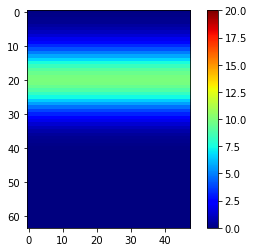

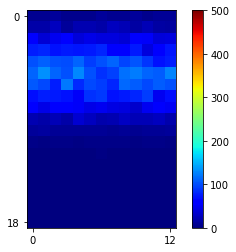

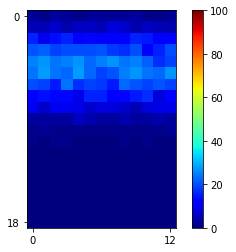

torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247]

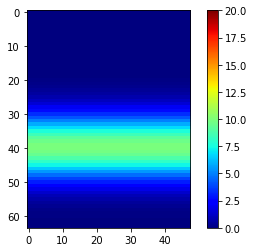

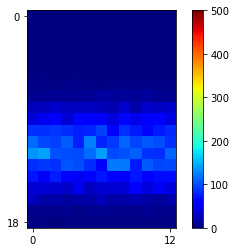

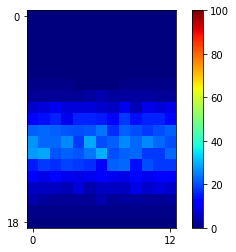

torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247]

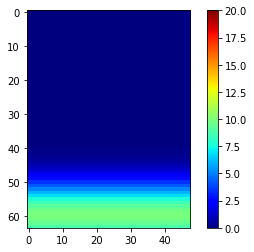

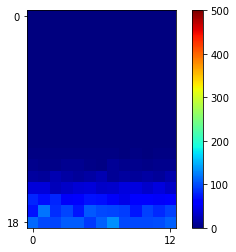

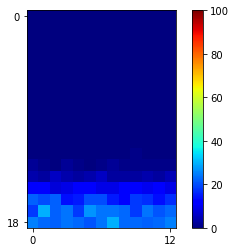

torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247]

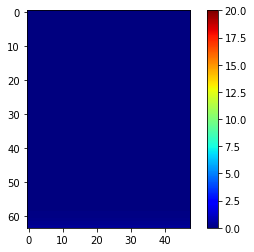

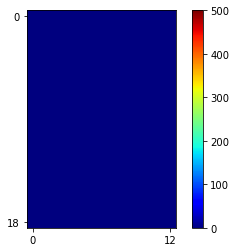

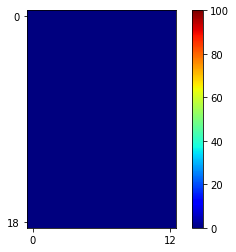

torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([1304, 247]

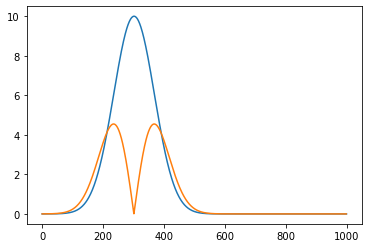

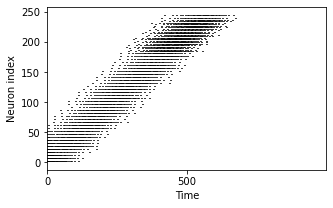

torch.Size([247, 999])


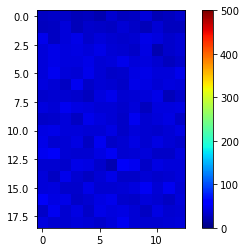

0 187


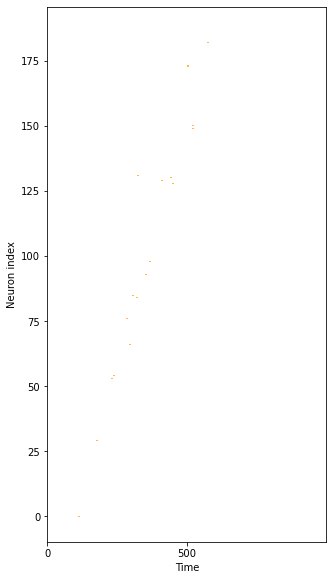

187 374


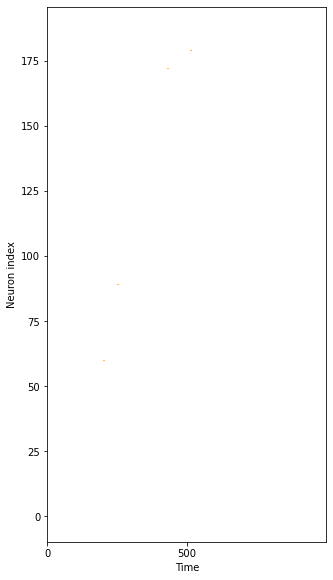

374 561


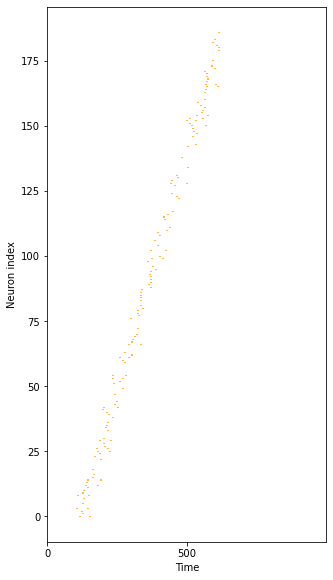

561 748


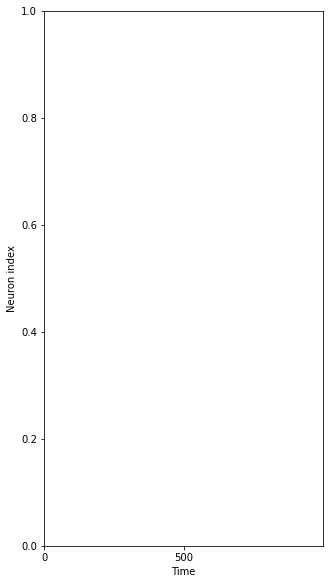

748 839


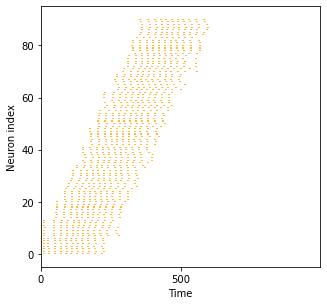

839 930


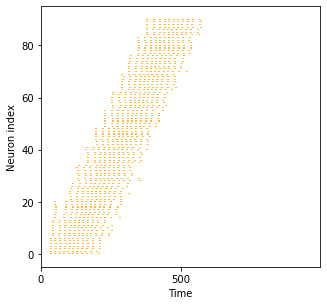

930 1117


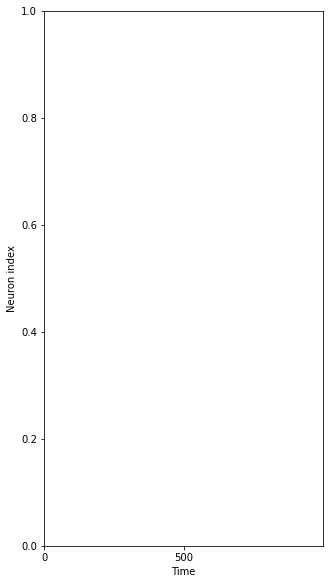

1117 1304


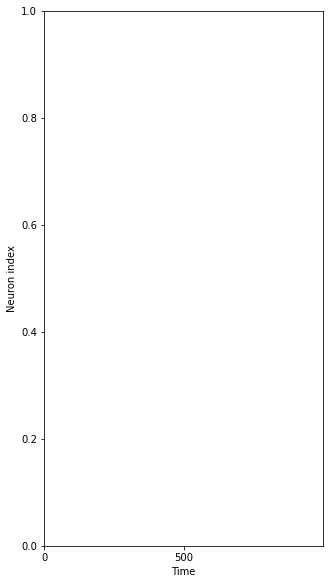

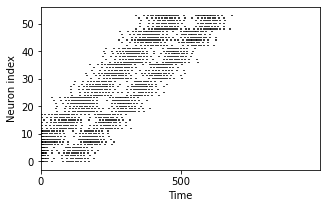

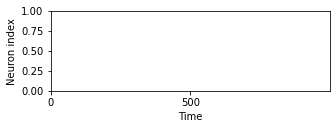

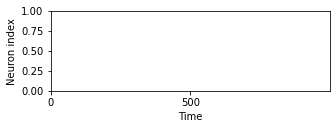

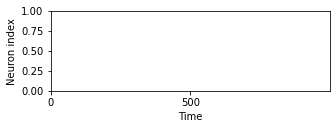

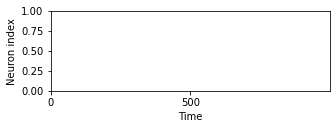

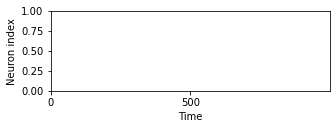

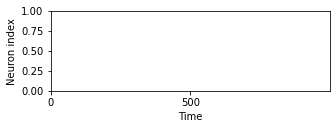

8.194010734558105
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
stim = stimulation_angle_0
start_time = time.time()
[SA, RA] = run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
                          SA_rf_length, RA_rf_length, stim, device=device)
end_time = time.time()

print(end_time - start_time)

print(SA.layers[0].spike_buffer)

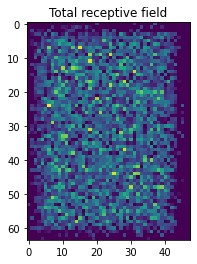

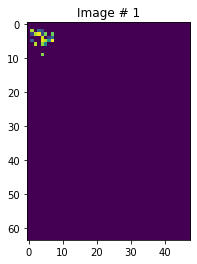

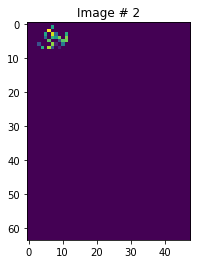

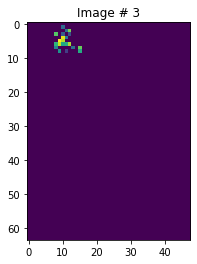

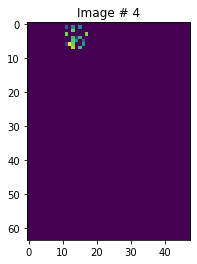

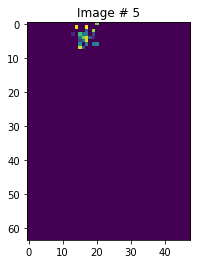

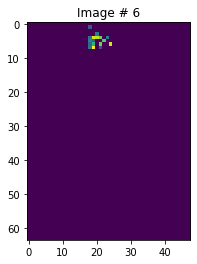

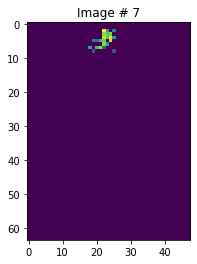

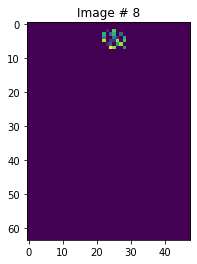

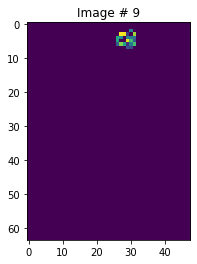

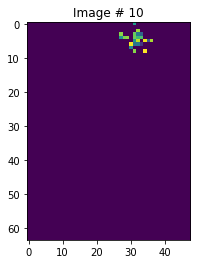

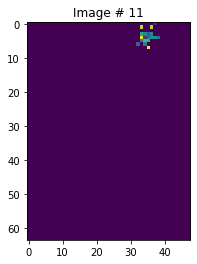

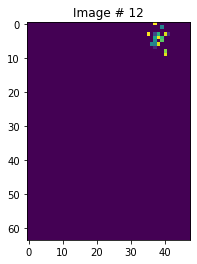

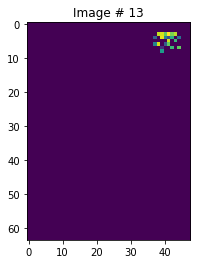

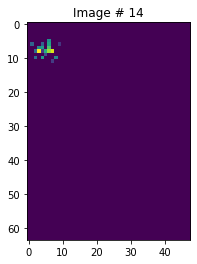

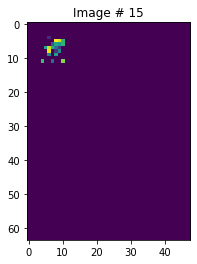

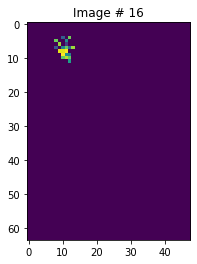

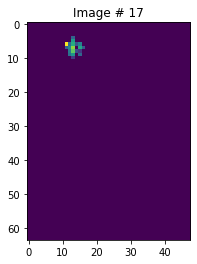

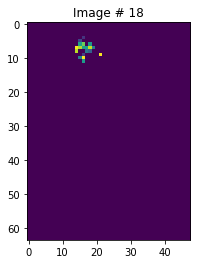

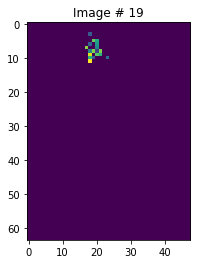

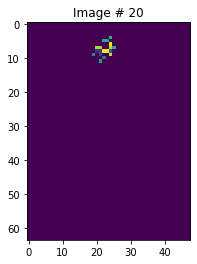

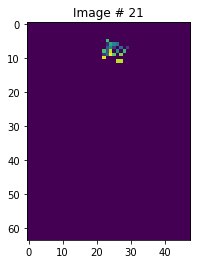

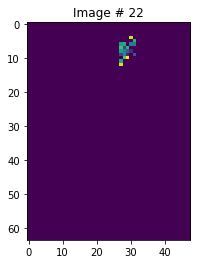

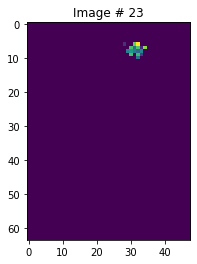

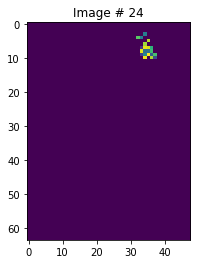

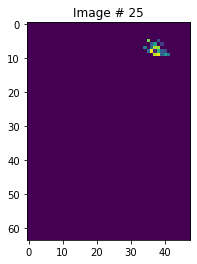

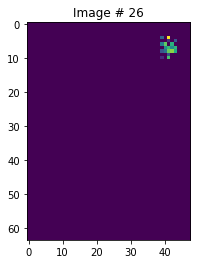

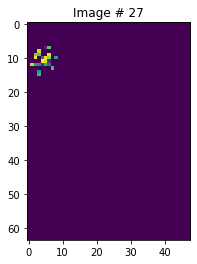

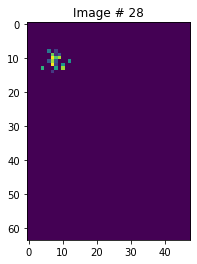

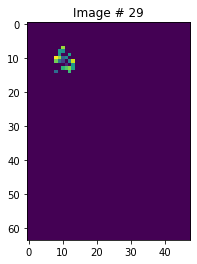

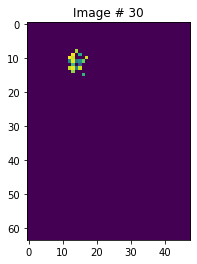

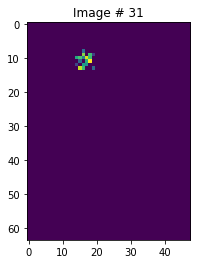

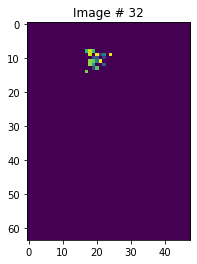

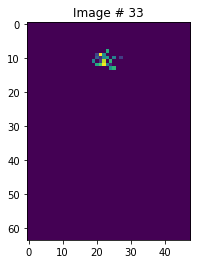

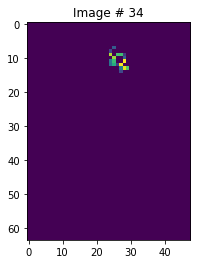

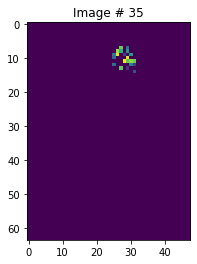

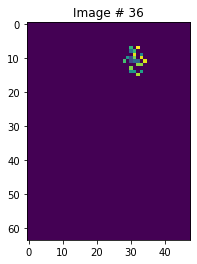

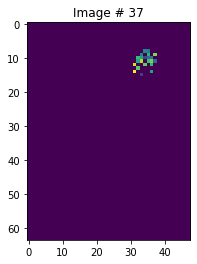

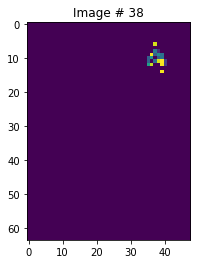

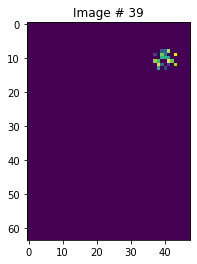

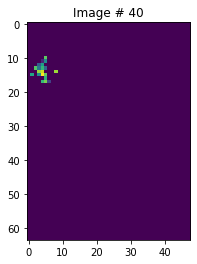

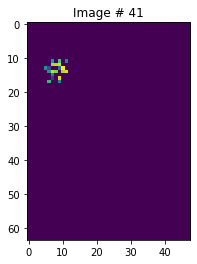

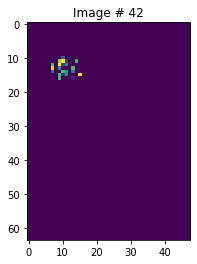

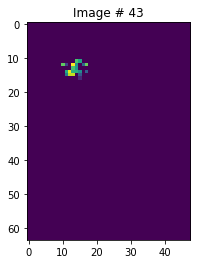

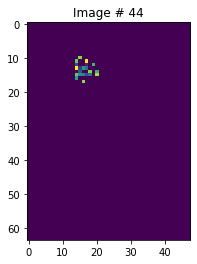

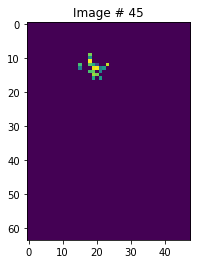

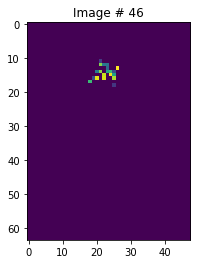

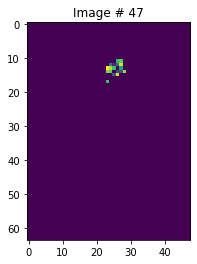

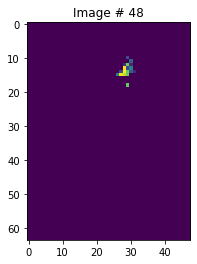

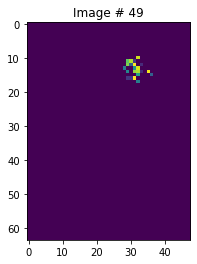

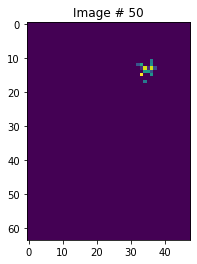

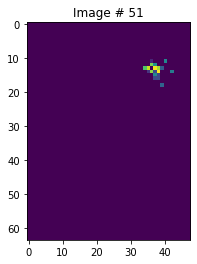

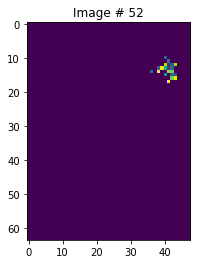

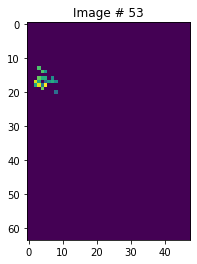

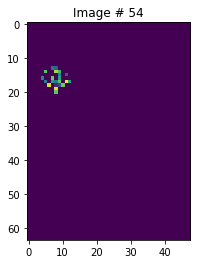

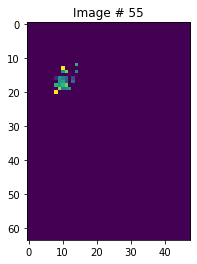

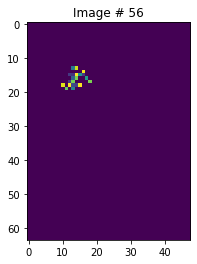

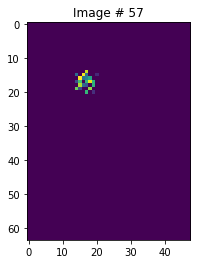

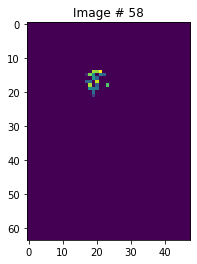

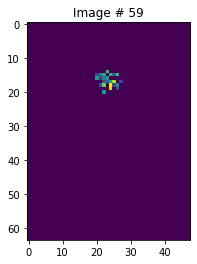

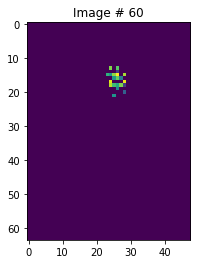

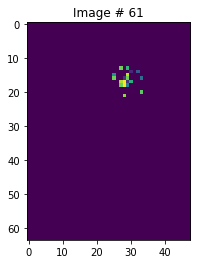

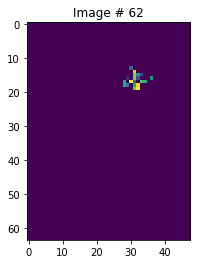

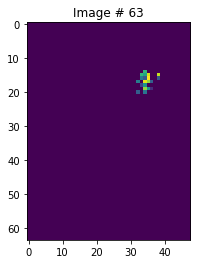

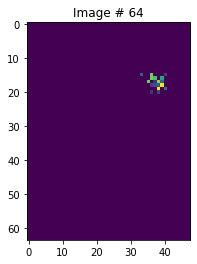

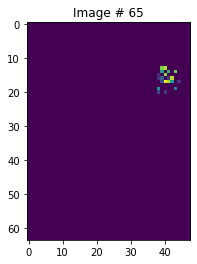

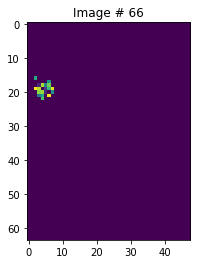

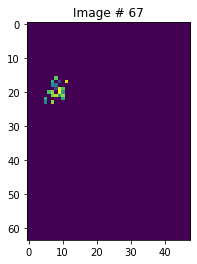

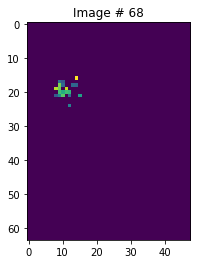

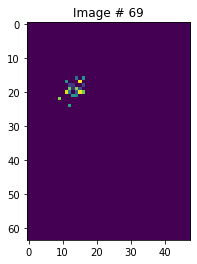

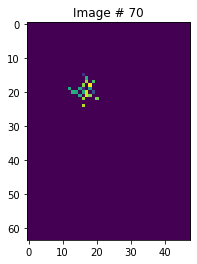

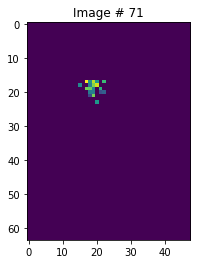

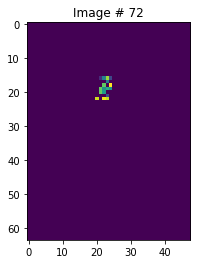

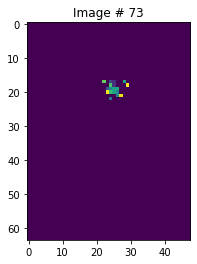

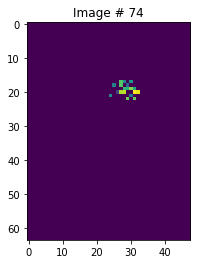

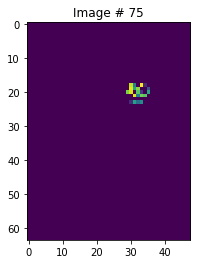

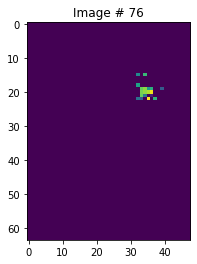

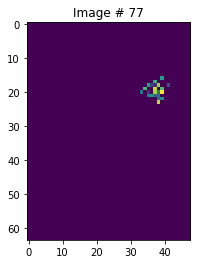

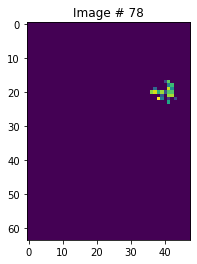

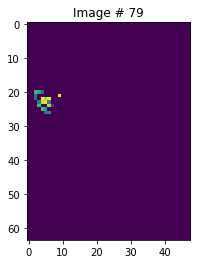

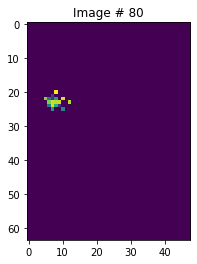

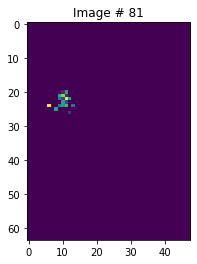

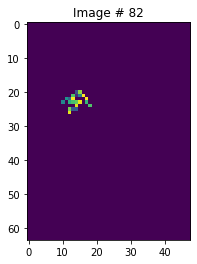

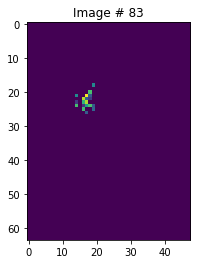

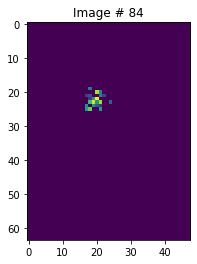

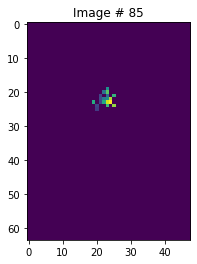

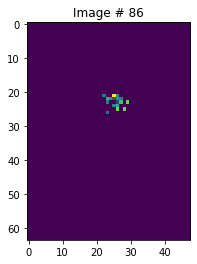

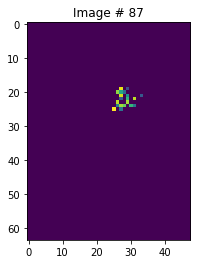

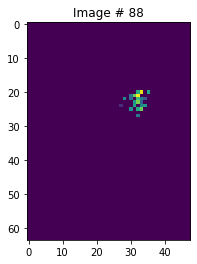

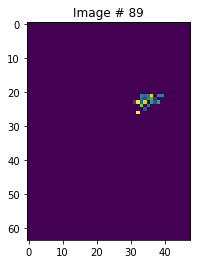

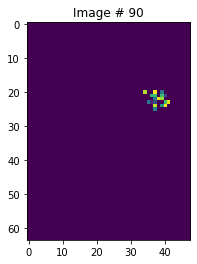

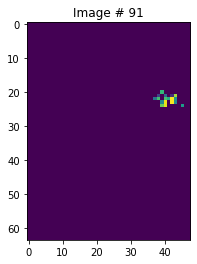

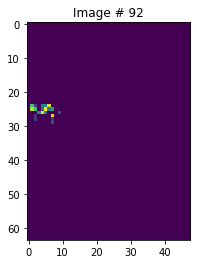

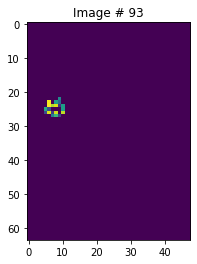

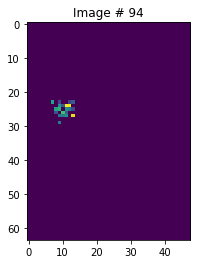

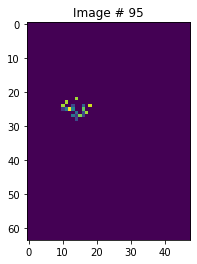

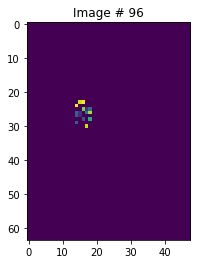

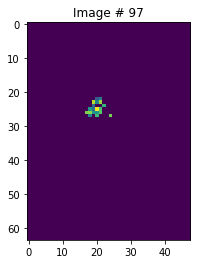

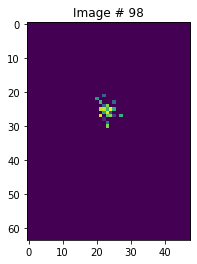

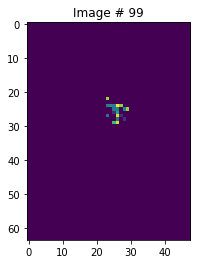

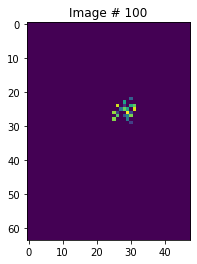

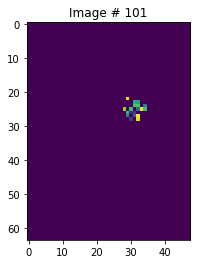

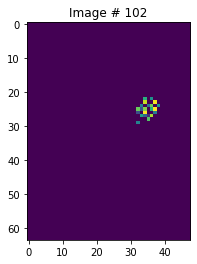

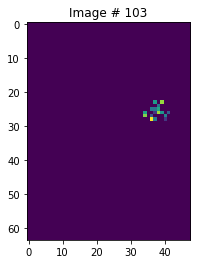

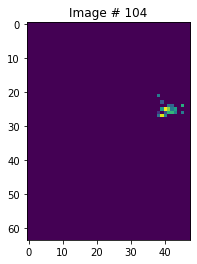

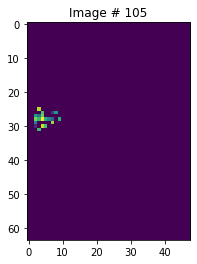

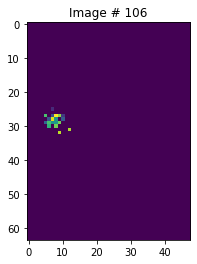

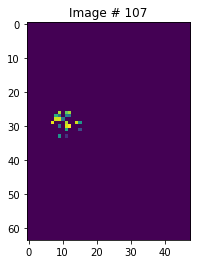

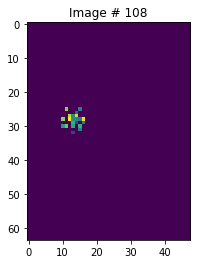

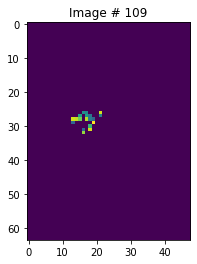

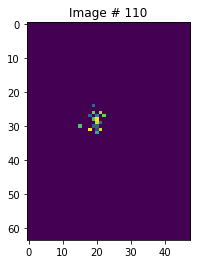

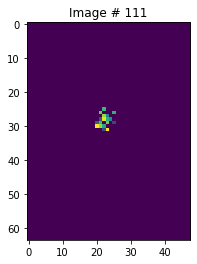

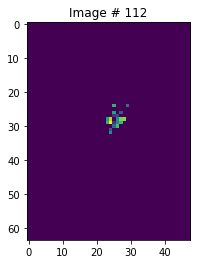

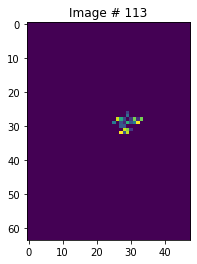

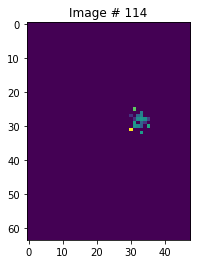

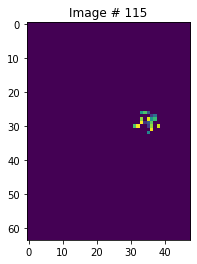

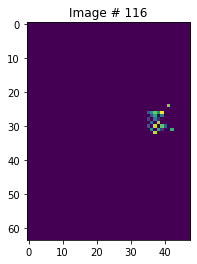

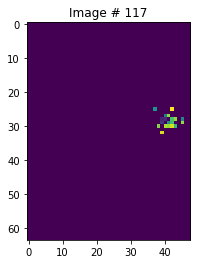

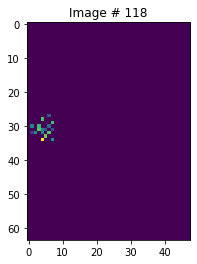

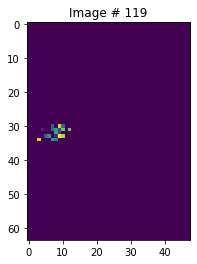

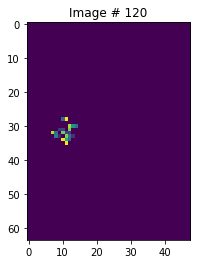

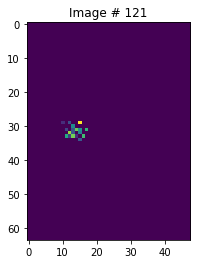

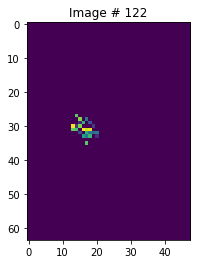

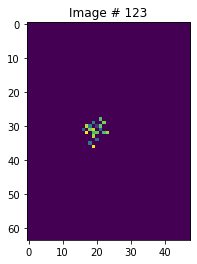

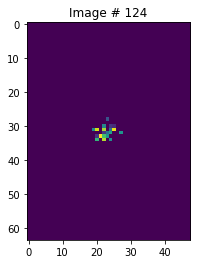

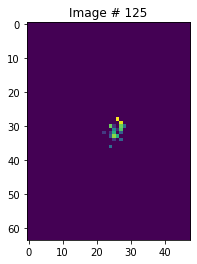

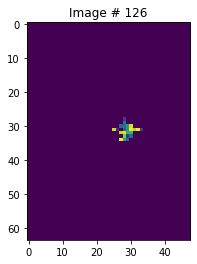

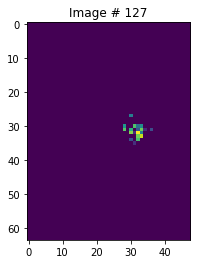

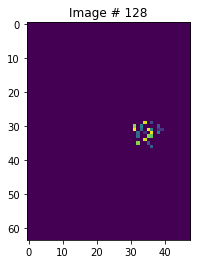

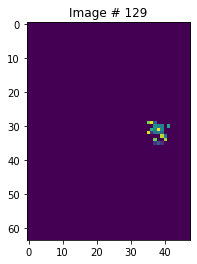

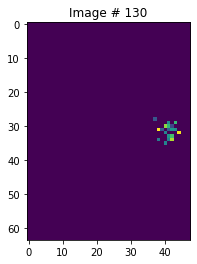

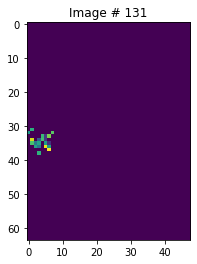

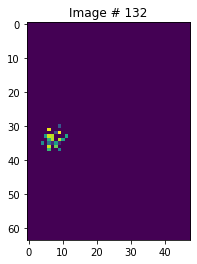

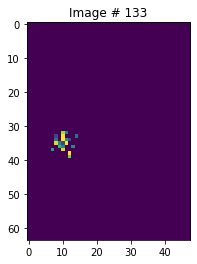

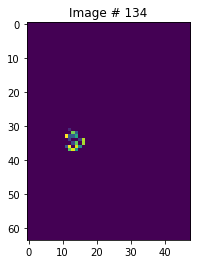

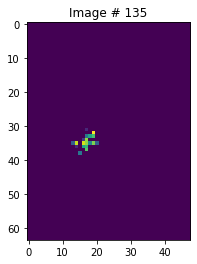

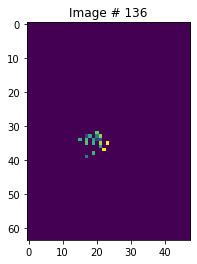

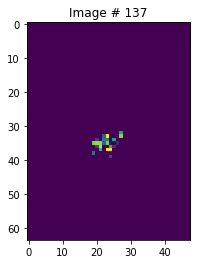

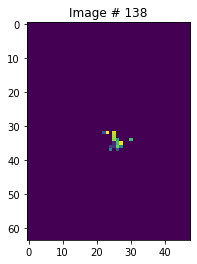

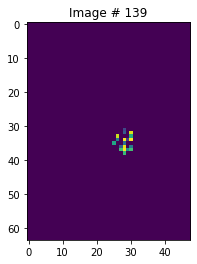

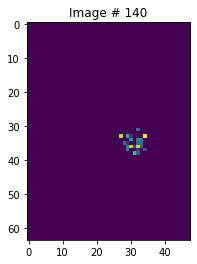

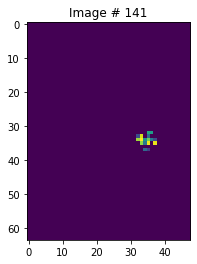

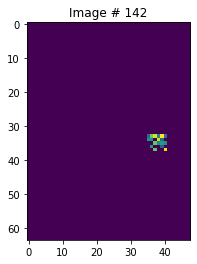

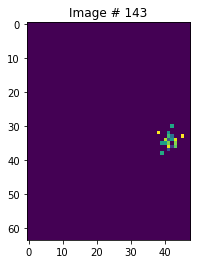

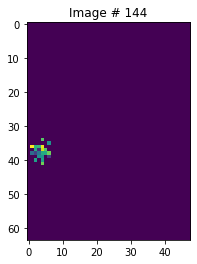

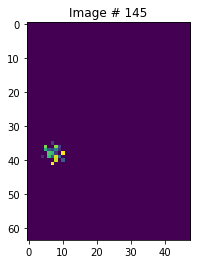

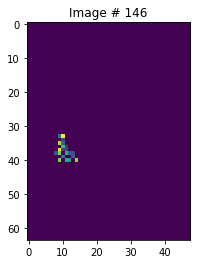

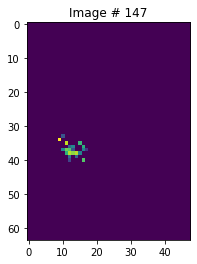

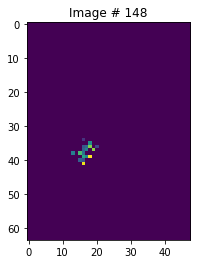

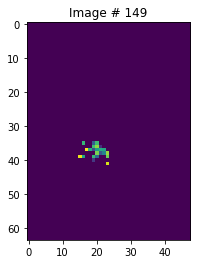

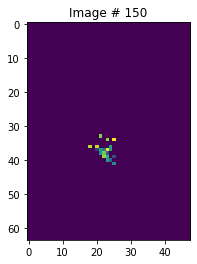

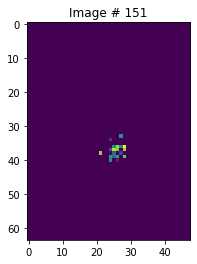

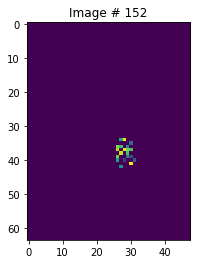

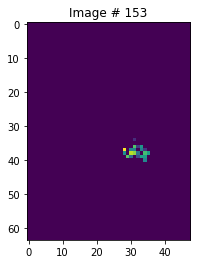

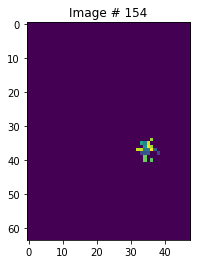

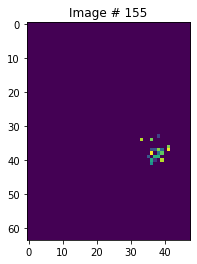

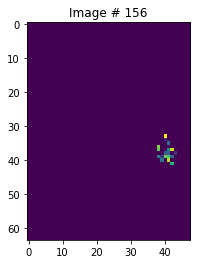

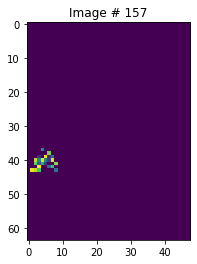

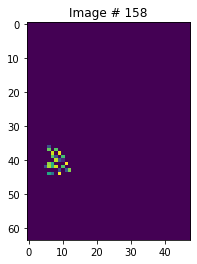

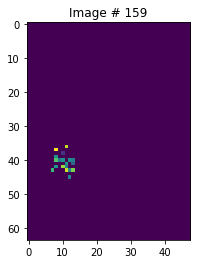

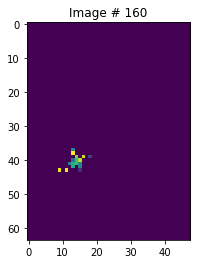

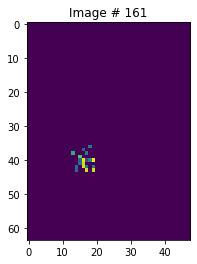

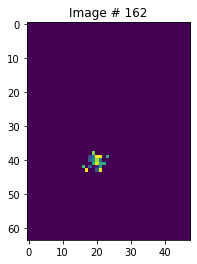

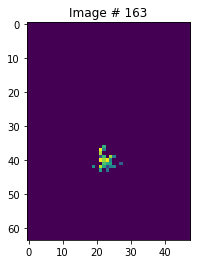

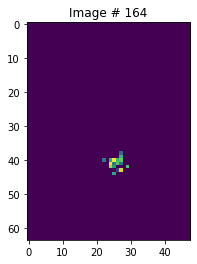

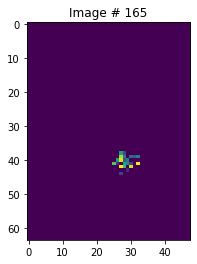

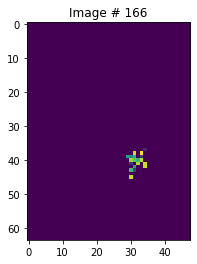

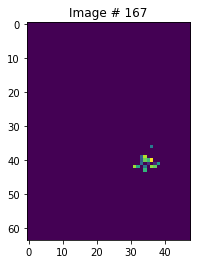

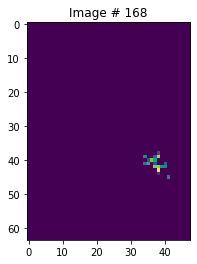

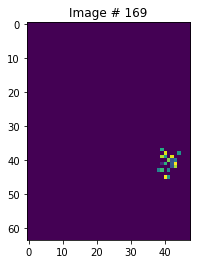

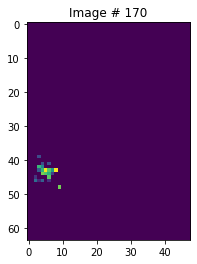

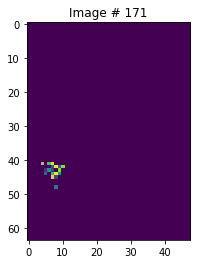

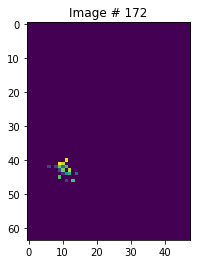

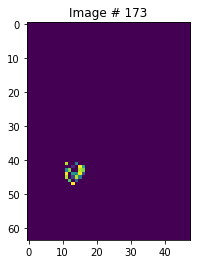

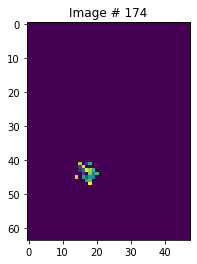

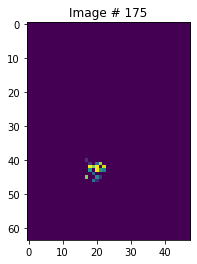

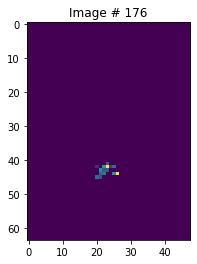

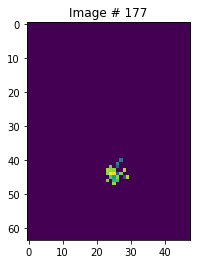

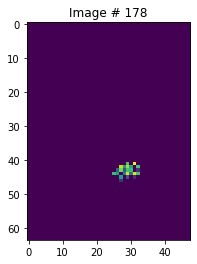

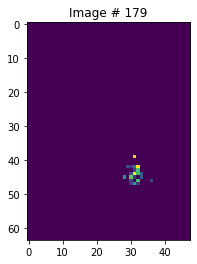

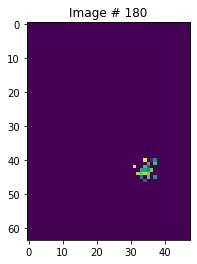

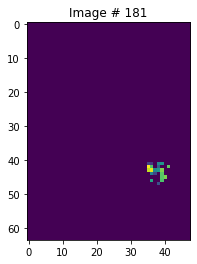

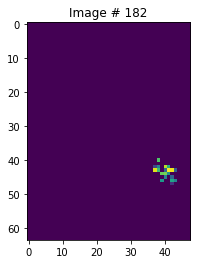

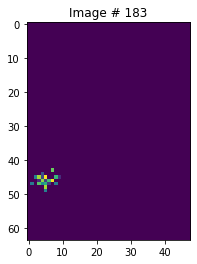

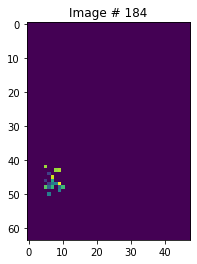

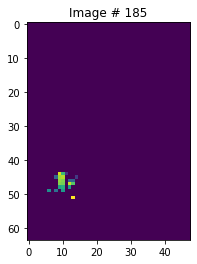

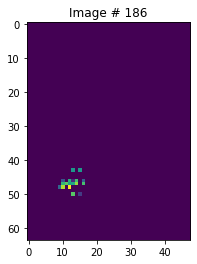

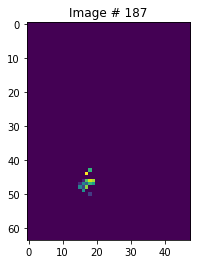

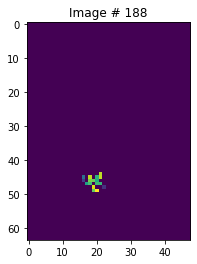

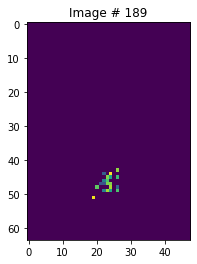

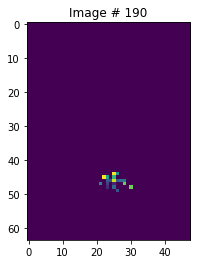

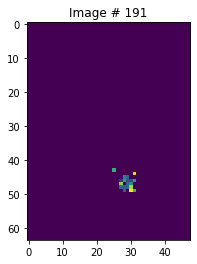

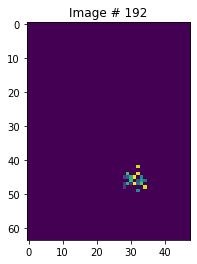

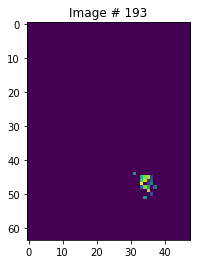

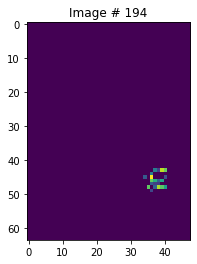

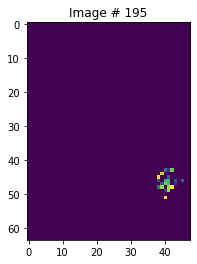

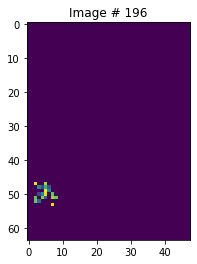

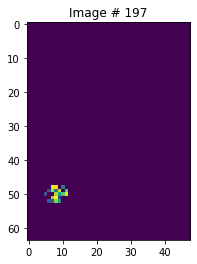

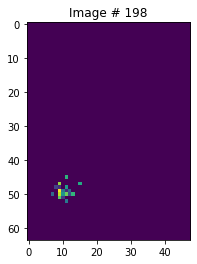

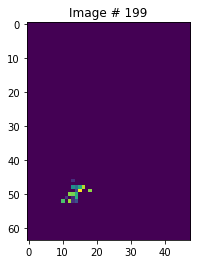

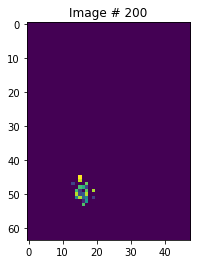

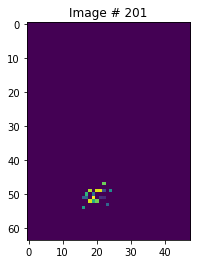

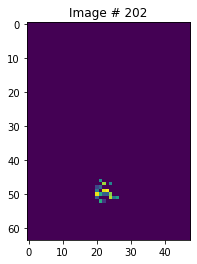

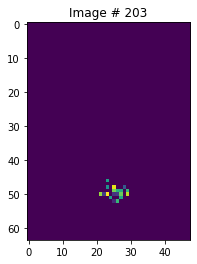

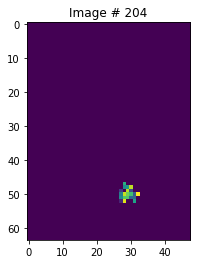

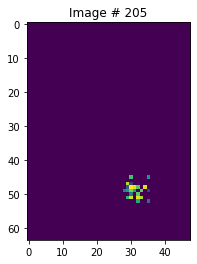

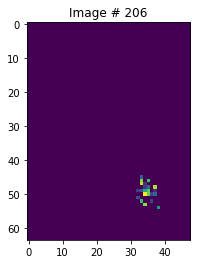

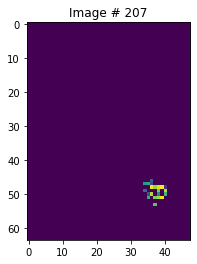

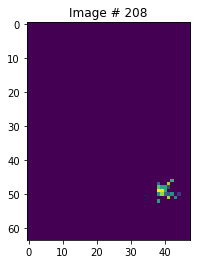

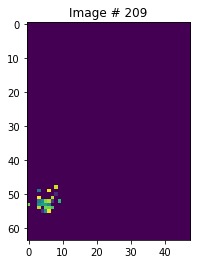

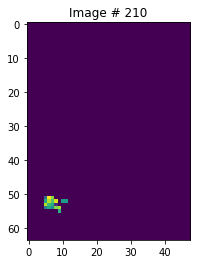

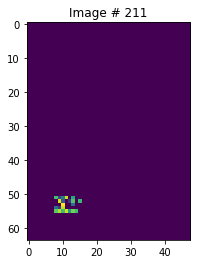

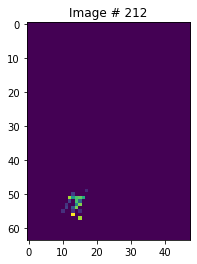

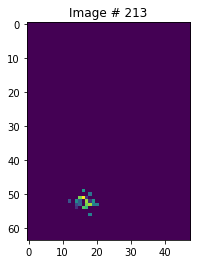

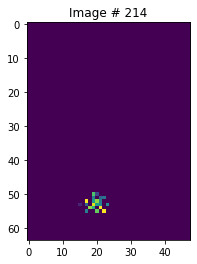

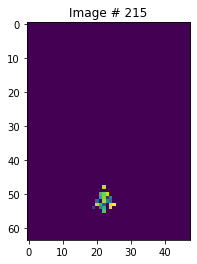

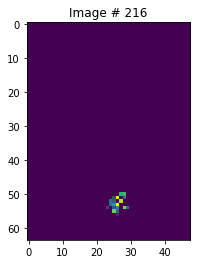

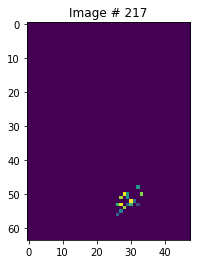

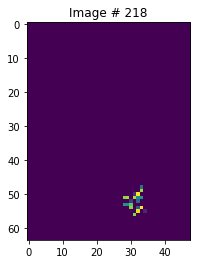

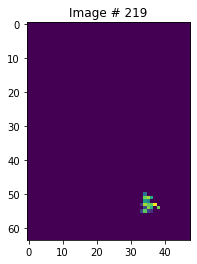

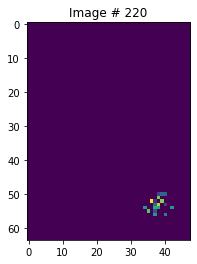

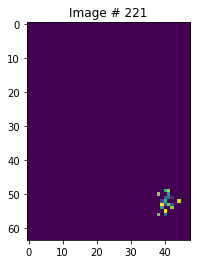

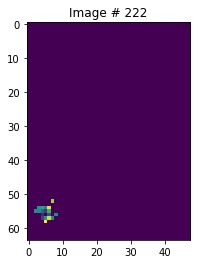

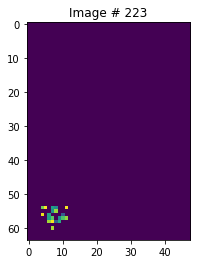

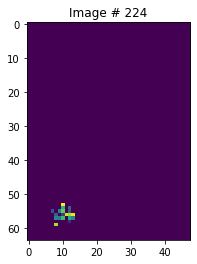

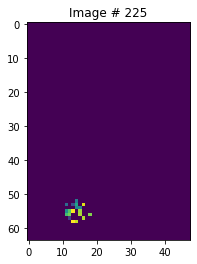

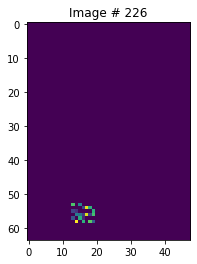

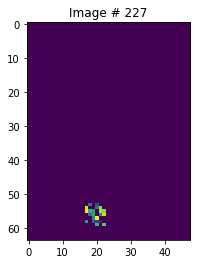

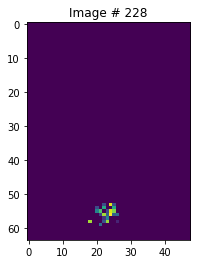

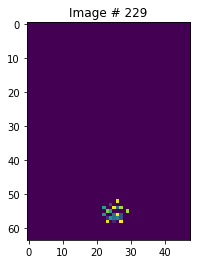

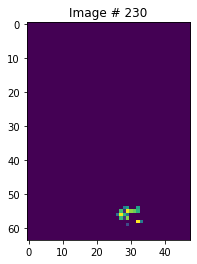

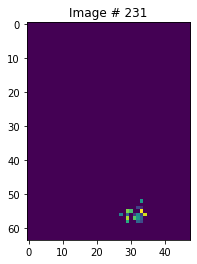

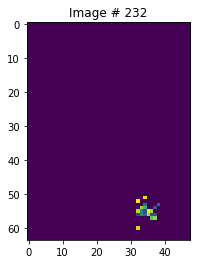

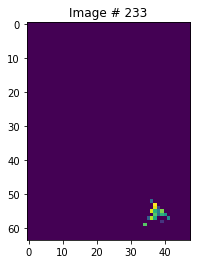

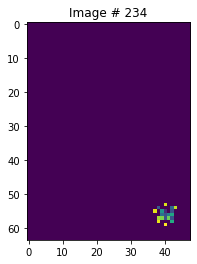

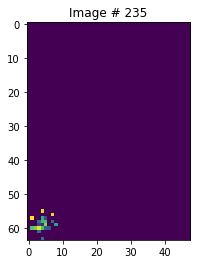

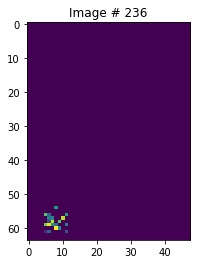

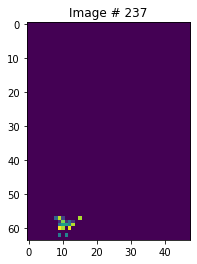

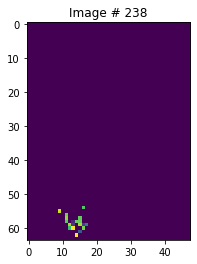

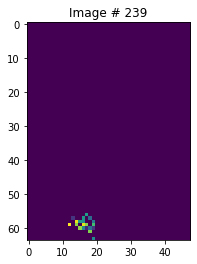

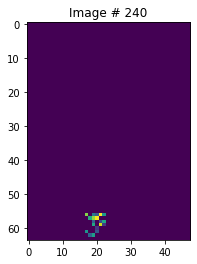

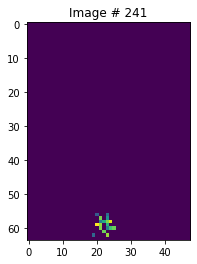

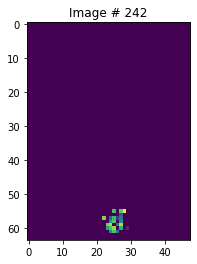

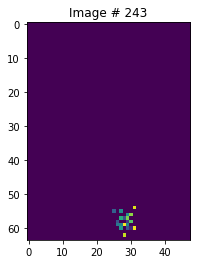

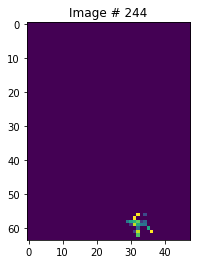

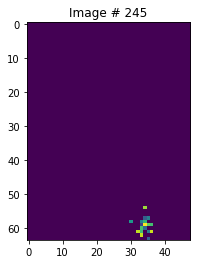

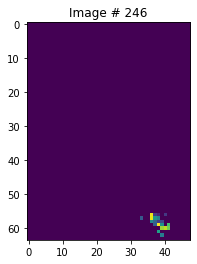

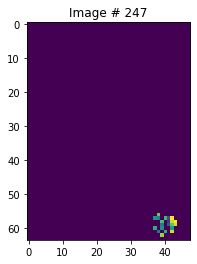

In [10]:
plt.figure()
plt.imshow(torch.sum(SA_rf, axis=0).reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
plt.title('Total receptive field')
plt.show()

for i in range(len(SA_rf)):
    plt.figure()
    plt.imshow(SA_rf[i].reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()


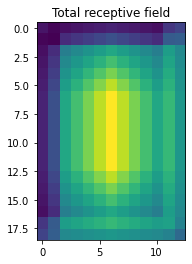

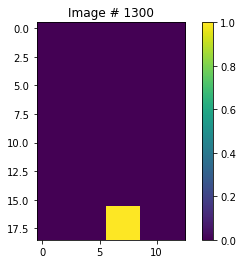

In [11]:
plt.figure()
plt.imshow(torch.sum(SA_rf_top, axis=0).reshape(19, 13).cpu().numpy(), cmap='viridis')
plt.title('Total receptive field')
plt.show()

for i in range(1299,1300):
    plt.figure()
    plt.imshow(SA_rf_top[i].reshape(19, 13).cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Image # {}'.format(i+1))
    plt.show()
